In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install tensorflow
!pip install tflite_support
!pip install flatbuffers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 38.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 53.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 63.2 MB/s eta 0:00:00:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: h5py
    Found existing installation: h5py 3.7.0
    Uninstalling h5py-3.7.0:
      Successfully uninstalled h5py-3.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.10.1
    Uninstalling tensorboard-2.10.1:
      Successfully uninstalled tensorboard-2.10.1
ERROR: pip's dependency resolver does not currently take into account

In [3]:
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report,confusion_matrix


from tflite_support import metadata_schema_py_generated as _metadata_fb
from tflite_support import metadata as _metadata
import flatbuffers

In [4]:
IMAGES_PATH = "../input/citypersondata/leftImg8bit_trainvaltest/leftImg8bit"
ANNOTS_PATH = "../input/citypersondata/gtBboxCityPersonsWithDangerLevel/gtBboxCityPersonsWithDangerLevel"
BASE_OUTPUT = "output"

TRAIN_FILENAMES = "../input/citypersondata-annot/train.txt"
TEST_FILENAMES = "../input/citypersondata-annot/test.txt"
VAL_FILENAMES = "../input/citypersondata-annot/val.txt"

NUM_CLASSES = 3
OUTPUT_CLASSES = 4 #classes + background

INIT_LR = 1e-4
NUM_EPOCHS = 1
BATCH_SIZE = 16
BUFFER_SIZE = 40

IMG_H = 512#224#512 #384 #360
IMG_W = 512 #224 #512 #512 #480

In [5]:
def getClassFromJson(json_path):
    json_f = open(json_path)
    data = json.load(json_f)
    objects = data["objects"]
    highest_num = 0
    for o in objects:
        danger_level = None
        if "danger_level" in o:
            danger_level = int(o["danger_level"])
        else:
            danger_level = int(o["my_label"])
        
        
        if highest_num < danger_level:
            highest_num = danger_level
        if highest_num == 3:
            break
    return highest_num

In [6]:
def returnNamesLabels(filename):
    trainDataNames = []
    trainDataLabels = []
    f = open(filename, "r")
    for r in f:
        r = r.split(",") #image path, annotation path
        img_path = r[0]
        annot_path = r[1][:-1] #without \n
        class_num = getClassFromJson(annot_path)
        trainDataNames.append(img_path)
        trainDataLabels.append(class_num)
    f.close()
    return trainDataNames, trainDataLabels

In [7]:
trainDataNames, trainDataLabels = returnNamesLabels(TRAIN_FILENAMES)
valDataNames, valDataLabels = returnNamesLabels(VAL_FILENAMES)
testDataNames, testDataLabels = returnNamesLabels(TEST_FILENAMES)

allDataNames = trainDataNames + valDataNames + testDataNames
allDataLabels = trainDataLabels + valDataLabels + testDataLabels

In [8]:
X_train, X_test, y_train, y_test = train_test_split(allDataNames, allDataLabels, test_size=0.1438, random_state=42, shuffle=True, stratify=allDataLabels)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.122689, random_state=42, shuffle=True, stratify=y_train)

In [9]:
print(len(y_test))
print(len(y_train))
print(len(y_val))

STEPS_PER_EPOCH = len(y_train) // BATCH_SIZE

500
2610
365


In [10]:
def showDataPlot(trainDataLabels):
    l = []
    for i in trainDataLabels:
        if i == 0:
            l.append("ignore")
        elif i == 1:
            l.append("safe pedestrian")
        elif i == 2:
            l.append("be careful")
        elif i == 3:
            l.append("break")
        else:
            print("should not happen")
    sns.set_style('darkgrid')
    sns.countplot(x=l, order=["ignore", "safe pedestrian", "be careful", "break"])
    print("ignore: " + str(l.count("ignore")))
    print("safe pedestrian: " + str(l.count("safe pedestrian")))
    print("be careful: " + str(l.count("be careful")))
    print("break: " + str(l.count("break")))

ignore: 401
safe pedestrian: 1500
be careful: 471
break: 238


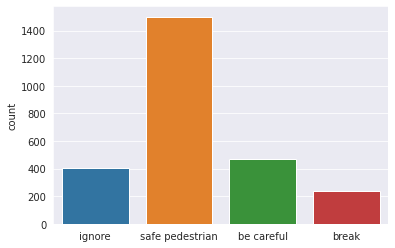

In [11]:
showDataPlot(y_train)

ignore: 56
safe pedestrian: 210
be careful: 66
break: 33


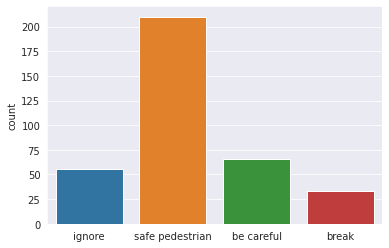

In [12]:
showDataPlot(y_val)

ignore: 77
safe pedestrian: 287
be careful: 90
break: 46


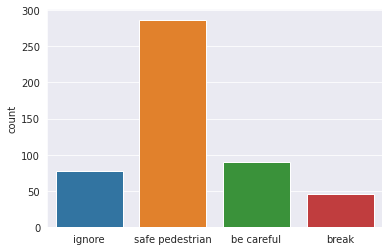

In [13]:
showDataPlot(y_test)

In [14]:
def normalize(input_image, label):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, label

def read_image(image_path, h, w):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    return tf.image.resize(image, [h, w])

def load_image(image_path, label, imageH, imageW):
    input_image = read_image(image_path, imageH, imageW)
    input_image, label = normalize(input_image, label)
    return input_image, label

In [15]:
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_images = dataset_train.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)

dataset_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_images = dataset_val.map(lambda x, y: load_image(x, y, IMG_H, IMG_W), num_parallel_calls=tf.data.AUTOTUNE)

2022-12-07 07:14:47.771041: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        return inputs, labels

In [17]:
train_batches = (
        train_images
        .cache()
        .shuffle(BUFFER_SIZE)
        .batch(BATCH_SIZE)
        .repeat()
        .map(Augment())
        .prefetch(buffer_size=tf.data.AUTOTUNE))

In [18]:
val_batches = val_images.batch(BATCH_SIZE)

In [19]:
base_model = tf.keras.applications.MobileNetV2(input_shape = (IMG_H, IMG_W, 3), include_top = False, weights = "imagenet")

9420800/9406464 [==============================] - 0s 0us/step


In [20]:
base_model.trainable = True

In [21]:
model = tf.keras.Sequential([base_model,
                                 tf.keras.layers.GlobalAveragePooling2D(),
                                 tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(64, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(32, activation="relu"),
                             tf.keras.layers.Dropout(0.2),
                                 tf.keras.layers.Dense(4)                                     
                                ])

In [22]:
base_learning_rate = 0.00001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              loss_weights=[2.5, 0.67, 2.12, 4.2],
              metrics=['accuracy'])


ep = 10
history = model.fit(train_batches,epochs = ep , validation_data = val_batches, steps_per_epoch=STEPS_PER_EPOCH)

2022-12-07 07:14:50.300728: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

  1/163 [..............................] - ETA: 44:30 - loss: 4.8113 - accuracy: 0.0000e+00

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  2/163 [..............................] - ETA: 12:29 - loss: 4.3552 - accuracy: 0.0312    

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  3/163 [..............................] - ETA: 12:19 - loss: 4.2343 - accuracy: 0.1250

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  4/163 [..............................] - ETA: 12:10 - loss: 4.3145 - accuracy: 0.0938

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  5/163 [..............................] - ETA: 12:32 - loss: 4.2852 - accuracy: 0.1125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  6/163 [>.............................] - ETA: 12:18 - loss: 4.2370 - accuracy: 0.1146

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  7/163 [>.............................] - ETA: 12:11 - loss: 4.2502 - accuracy: 0.0982

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  8/163 [>.............................] - ETA: 12:02 - loss: 4.2053 - accuracy: 0.1172

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


  9/163 [>.............................] - ETA: 11:54 - loss: 4.2020 - accuracy: 0.1181

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 10/163 [>.............................] - ETA: 11:51 - loss: 4.1575 - accuracy: 0.1312

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 11/163 [=>............................] - ETA: 11:45 - loss: 4.0959 - accuracy: 0.1534

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 12/163 [=>............................] - ETA: 11:47 - loss: 4.0878 - accuracy: 0.1458

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 13/163 [=>............................] - ETA: 11:40 - loss: 4.0896 - accuracy: 0.1538

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 14/163 [=>............................] - ETA: 11:34 - loss: 4.0503 - accuracy: 0.1652

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 15/163 [=>............................] - ETA: 11:28 - loss: 4.0114 - accuracy: 0.1708

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 16/163 [=>............................] - ETA: 11:21 - loss: 4.0125 - accuracy: 0.1680

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 17/163 [==>...........................] - ETA: 11:17 - loss: 3.9925 - accuracy: 0.1765

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 18/163 [==>...........................] - ETA: 11:12 - loss: 3.9859 - accuracy: 0.1736

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 19/163 [==>...........................] - ETA: 11:09 - loss: 3.9821 - accuracy: 0.1711

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 20/163 [==>...........................] - ETA: 11:03 - loss: 3.9639 - accuracy: 0.1750

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 21/163 [==>...........................] - ETA: 10:58 - loss: 3.9824 - accuracy: 0.1726

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 22/163 [===>..........................] - ETA: 10:53 - loss: 3.9716 - accuracy: 0.1733

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 23/163 [===>..........................] - ETA: 10:47 - loss: 3.9863 - accuracy: 0.1685

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 24/163 [===>..........................] - ETA: 10:42 - loss: 3.9878 - accuracy: 0.1667

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 25/163 [===>..........................] - ETA: 10:39 - loss: 3.9857 - accuracy: 0.1675

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 26/163 [===>..........................] - ETA: 10:35 - loss: 4.0080 - accuracy: 0.1635

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 27/163 [===>..........................] - ETA: 10:30 - loss: 3.9909 - accuracy: 0.1667

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 28/163 [====>.........................] - ETA: 10:25 - loss: 3.9819 - accuracy: 0.1652

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 29/163 [====>.........................] - ETA: 10:19 - loss: 3.9756 - accuracy: 0.1659

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 30/163 [====>.........................] - ETA: 10:14 - loss: 3.9594 - accuracy: 0.1667

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 31/163 [====>.........................] - ETA: 10:09 - loss: 3.9507 - accuracy: 0.1714

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 32/163 [====>.........................] - ETA: 10:06 - loss: 3.9399 - accuracy: 0.1719

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 33/163 [=====>........................] - ETA: 10:00 - loss: 3.9239 - accuracy: 0.1742

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 34/163 [=====>........................] - ETA: 9:55 - loss: 3.9230 - accuracy: 0.1710 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 35/163 [=====>........................] - ETA: 9:50 - loss: 3.9184 - accuracy: 0.1732

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 36/163 [=====>........................] - ETA: 9:45 - loss: 3.9128 - accuracy: 0.1771

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 37/163 [=====>........................] - ETA: 9:40 - loss: 3.9009 - accuracy: 0.1791

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 38/163 [=====>........................] - ETA: 9:36 - loss: 3.8942 - accuracy: 0.1760

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 39/163 [======>.......................] - ETA: 9:33 - loss: 3.8926 - accuracy: 0.1779

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 40/163 [======>.......................] - ETA: 9:28 - loss: 3.8835 - accuracy: 0.1813

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 41/163 [======>.......................] - ETA: 9:23 - loss: 3.8801 - accuracy: 0.1784

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 42/163 [======>.......................] - ETA: 9:18 - loss: 3.8773 - accuracy: 0.1801

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 43/163 [======>.......................] - ETA: 9:13 - loss: 3.8758 - accuracy: 0.1817

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 44/163 [=======>......................] - ETA: 9:08 - loss: 3.8798 - accuracy: 0.1790

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 45/163 [=======>......................] - ETA: 9:03 - loss: 3.8737 - accuracy: 0.1792

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 46/163 [=======>......................] - ETA: 9:00 - loss: 3.8651 - accuracy: 0.1807

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 47/163 [=======>......................] - ETA: 8:55 - loss: 3.8614 - accuracy: 0.1809

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 48/163 [=======>......................] - ETA: 8:50 - loss: 3.8573 - accuracy: 0.1797

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 49/163 [========>.....................] - ETA: 8:46 - loss: 3.8418 - accuracy: 0.1824

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 50/163 [========>.....................] - ETA: 8:42 - loss: 3.8326 - accuracy: 0.1838

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 51/163 [========>.....................] - ETA: 8:37 - loss: 3.8187 - accuracy: 0.1875

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 52/163 [========>.....................] - ETA: 8:32 - loss: 3.8138 - accuracy: 0.1887

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 53/163 [========>.....................] - ETA: 8:29 - loss: 3.8104 - accuracy: 0.1910

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 54/163 [========>.....................] - ETA: 8:24 - loss: 3.8030 - accuracy: 0.1910

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 55/163 [=========>....................] - ETA: 8:19 - loss: 3.8011 - accuracy: 0.1920

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 56/163 [=========>....................] - ETA: 8:14 - loss: 3.7967 - accuracy: 0.1942

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 57/163 [=========>....................] - ETA: 8:10 - loss: 3.7776 - accuracy: 0.2007

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 58/163 [=========>....................] - ETA: 8:05 - loss: 3.7698 - accuracy: 0.2004

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 59/163 [=========>....................] - ETA: 8:00 - loss: 3.7644 - accuracy: 0.2023

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 60/163 [==========>...................] - ETA: 7:56 - loss: 3.7583 - accuracy: 0.2042

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 61/163 [==========>...................] - ETA: 7:52 - loss: 3.7555 - accuracy: 0.2049

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 62/163 [==========>...................] - ETA: 7:48 - loss: 3.7499 - accuracy: 0.2056

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 63/163 [==========>...................] - ETA: 7:43 - loss: 3.7485 - accuracy: 0.2073

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 64/163 [==========>...................] - ETA: 7:38 - loss: 3.7405 - accuracy: 0.2129

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 65/163 [==========>...................] - ETA: 7:34 - loss: 3.7405 - accuracy: 0.2144

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 66/163 [===========>..................] - ETA: 7:30 - loss: 3.7413 - accuracy: 0.2140

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 67/163 [===========>..................] - ETA: 7:25 - loss: 3.7345 - accuracy: 0.2164

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 68/163 [===========>..................] - ETA: 7:20 - loss: 3.7311 - accuracy: 0.2197

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 69/163 [===========>..................] - ETA: 7:15 - loss: 3.7192 - accuracy: 0.2228

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 70/163 [===========>..................] - ETA: 7:11 - loss: 3.7149 - accuracy: 0.2259

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 71/163 [============>.................] - ETA: 7:06 - loss: 3.7138 - accuracy: 0.2280

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 72/163 [============>.................] - ETA: 7:01 - loss: 3.7112 - accuracy: 0.2283

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 73/163 [============>.................] - ETA: 6:57 - loss: 3.7099 - accuracy: 0.2277

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 74/163 [============>.................] - ETA: 6:53 - loss: 3.7048 - accuracy: 0.2289

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 75/163 [============>.................] - ETA: 6:48 - loss: 3.6951 - accuracy: 0.2325

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 76/163 [============>.................] - ETA: 6:43 - loss: 3.6898 - accuracy: 0.2360

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 77/163 [=============>................] - ETA: 6:38 - loss: 3.6900 - accuracy: 0.2370

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 78/163 [=============>................] - ETA: 6:33 - loss: 3.6843 - accuracy: 0.2380

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 79/163 [=============>................] - ETA: 6:29 - loss: 3.6817 - accuracy: 0.2381

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 80/163 [=============>................] - ETA: 6:25 - loss: 3.6725 - accuracy: 0.2414

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 81/163 [=============>................] - ETA: 6:20 - loss: 3.6729 - accuracy: 0.2384

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 82/163 [==============>...............] - ETA: 6:15 - loss: 3.6683 - accuracy: 0.2393

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 83/163 [==============>...............] - ETA: 6:11 - loss: 3.6598 - accuracy: 0.2425

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 84/163 [==============>...............] - ETA: 6:06 - loss: 3.6562 - accuracy: 0.2433

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 85/163 [==============>...............] - ETA: 6:01 - loss: 3.6537 - accuracy: 0.2441

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 86/163 [==============>...............] - ETA: 5:56 - loss: 3.6468 - accuracy: 0.2464

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 87/163 [===============>..............] - ETA: 5:52 - loss: 3.6418 - accuracy: 0.2486

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 88/163 [===============>..............] - ETA: 5:47 - loss: 3.6365 - accuracy: 0.2500

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 89/163 [===============>..............] - ETA: 5:43 - loss: 3.6286 - accuracy: 0.2542

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 90/163 [===============>..............] - ETA: 5:38 - loss: 3.6251 - accuracy: 0.2562

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 91/163 [===============>..............] - ETA: 5:33 - loss: 3.6214 - accuracy: 0.2582

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 92/163 [===============>..............] - ETA: 5:28 - loss: 3.6182 - accuracy: 0.2588

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 93/163 [================>.............] - ETA: 5:24 - loss: 3.6160 - accuracy: 0.2574

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 94/163 [================>.............] - ETA: 5:19 - loss: 3.6129 - accuracy: 0.2600

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 95/163 [================>.............] - ETA: 5:15 - loss: 3.6109 - accuracy: 0.2612

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 96/163 [================>.............] - ETA: 5:10 - loss: 3.6060 - accuracy: 0.2630

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 97/163 [================>.............] - ETA: 5:05 - loss: 3.6008 - accuracy: 0.2655

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 98/163 [=================>............] - ETA: 5:01 - loss: 3.5970 - accuracy: 0.2672

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


 99/163 [=================>............] - ETA: 4:56 - loss: 3.5949 - accuracy: 0.2677

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


100/163 [=================>............] - ETA: 4:53 - loss: 3.5882 - accuracy: 0.2694

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


101/163 [=================>............] - ETA: 4:48 - loss: 3.5865 - accuracy: 0.2698

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


102/163 [=================>............] - ETA: 4:44 - loss: 3.5804 - accuracy: 0.2727

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


103/163 [=================>............] - ETA: 4:39 - loss: 3.5750 - accuracy: 0.2749

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


104/163 [==================>...........] - ETA: 4:34 - loss: 3.5712 - accuracy: 0.2758

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


105/163 [==================>...........] - ETA: 4:29 - loss: 3.5666 - accuracy: 0.2774

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


106/163 [==================>...........] - ETA: 4:25 - loss: 3.5654 - accuracy: 0.2765

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


107/163 [==================>...........] - ETA: 4:20 - loss: 3.5590 - accuracy: 0.2792

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


108/163 [==================>...........] - ETA: 4:16 - loss: 3.5617 - accuracy: 0.2789

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


109/163 [===================>..........] - ETA: 4:11 - loss: 3.5526 - accuracy: 0.2827

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


110/163 [===================>..........] - ETA: 4:06 - loss: 3.5463 - accuracy: 0.2847

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


111/163 [===================>..........] - ETA: 4:02 - loss: 3.5395 - accuracy: 0.2877

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


112/163 [===================>..........] - ETA: 3:57 - loss: 3.5398 - accuracy: 0.2874

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


113/163 [===================>..........] - ETA: 3:52 - loss: 3.5372 - accuracy: 0.2898

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


114/163 [===================>..........] - ETA: 3:48 - loss: 3.5343 - accuracy: 0.2911

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


115/163 [====================>.........] - ETA: 3:43 - loss: 3.5314 - accuracy: 0.2929

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


116/163 [====================>.........] - ETA: 3:38 - loss: 3.5342 - accuracy: 0.2931

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


117/163 [====================>.........] - ETA: 3:33 - loss: 3.5336 - accuracy: 0.2943

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


118/163 [====================>.........] - ETA: 3:29 - loss: 3.5297 - accuracy: 0.2961

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


119/163 [====================>.........] - ETA: 3:24 - loss: 3.5270 - accuracy: 0.2983

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


120/163 [=====================>........] - ETA: 3:19 - loss: 3.5247 - accuracy: 0.2990

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


121/163 [=====================>........] - ETA: 3:15 - loss: 3.5188 - accuracy: 0.3011

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


122/163 [=====================>........] - ETA: 3:10 - loss: 3.5203 - accuracy: 0.3012

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


123/163 [=====================>........] - ETA: 3:05 - loss: 3.5167 - accuracy: 0.3028

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


124/163 [=====================>........] - ETA: 3:01 - loss: 3.5092 - accuracy: 0.3049

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


125/163 [======================>.......] - ETA: 2:56 - loss: 3.5053 - accuracy: 0.3065

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


126/163 [======================>.......] - ETA: 2:51 - loss: 3.5003 - accuracy: 0.3075

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


127/163 [======================>.......] - ETA: 2:47 - loss: 3.4962 - accuracy: 0.3095

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


128/163 [======================>.......] - ETA: 2:42 - loss: 3.4920 - accuracy: 0.3105

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


129/163 [======================>.......] - ETA: 2:37 - loss: 3.4865 - accuracy: 0.3120

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


130/163 [======================>.......] - ETA: 2:33 - loss: 3.4823 - accuracy: 0.3125

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


131/163 [=======================>......] - ETA: 2:28 - loss: 3.4795 - accuracy: 0.3135

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


132/163 [=======================>......] - ETA: 2:23 - loss: 3.4842 - accuracy: 0.3139

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


133/163 [=======================>......] - ETA: 2:19 - loss: 3.4844 - accuracy: 0.3144

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


134/163 [=======================>......] - ETA: 2:14 - loss: 3.4787 - accuracy: 0.3158

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


135/163 [=======================>......] - ETA: 2:09 - loss: 3.4837 - accuracy: 0.3157

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


136/163 [========================>.....] - ETA: 2:05 - loss: 3.4784 - accuracy: 0.3176

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


137/163 [========================>.....] - ETA: 2:00 - loss: 3.4743 - accuracy: 0.3193

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


138/163 [========================>.....] - ETA: 1:55 - loss: 3.4723 - accuracy: 0.3202

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


139/163 [========================>.....] - ETA: 1:51 - loss: 3.4702 - accuracy: 0.3219

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


140/163 [========================>.....] - ETA: 1:46 - loss: 3.4641 - accuracy: 0.3246

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


141/163 [========================>.....] - ETA: 1:42 - loss: 3.4593 - accuracy: 0.3262

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


142/163 [=========================>....] - ETA: 1:37 - loss: 3.4553 - accuracy: 0.3279

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


143/163 [=========================>....] - ETA: 1:32 - loss: 3.4556 - accuracy: 0.3282

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


144/163 [=========================>....] - ETA: 1:28 - loss: 3.4547 - accuracy: 0.3290

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


145/163 [=========================>....] - ETA: 1:23 - loss: 3.4503 - accuracy: 0.3306

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


146/163 [=========================>....] - ETA: 1:18 - loss: 3.4421 - accuracy: 0.3335

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


147/163 [==========================>...] - ETA: 1:14 - loss: 3.4412 - accuracy: 0.3350

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


148/163 [==========================>...] - ETA: 1:09 - loss: 3.4358 - accuracy: 0.3374

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


149/163 [==========================>...] - ETA: 1:04 - loss: 3.4333 - accuracy: 0.3385

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


150/163 [==========================>...] - ETA: 1:00 - loss: 3.4297 - accuracy: 0.3396

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


151/163 [==========================>...] - ETA: 55s - loss: 3.4273 - accuracy: 0.3402 

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


152/163 [==========================>...] - ETA: 50s - loss: 3.4243 - accuracy: 0.3417

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


153/163 [===========================>..] - ETA: 46s - loss: 3.4192 - accuracy: 0.3435

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


154/163 [===========================>..] - ETA: 41s - loss: 3.4171 - accuracy: 0.3442

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


155/163 [===========================>..] - ETA: 37s - loss: 3.4120 - accuracy: 0.3460

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


156/163 [===========================>..] - ETA: 32s - loss: 3.4073 - accuracy: 0.3478

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


157/163 [===========================>..] - ETA: 27s - loss: 3.4043 - accuracy: 0.3499

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


158/163 [============================>.] - ETA: 23s - loss: 3.4020 - accuracy: 0.3509

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


159/163 [============================>.] - ETA: 18s - loss: 3.3995 - accuracy: 0.3522

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...


163/163 [==============================] - ETA: 0s - loss: 3.3855 - accuracy: 0.3577

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 797s 5s/step - loss: 3.3855 - accuracy: 0.3577 - val_loss: 3.0755 - val_accuracy: 0.5452
Epoch 2/10
163/163 [==============================] - ETA: 0s - loss: 2.8777 - accuracy: 0.5474

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 695s 4s/step - loss: 2.8777 - accuracy: 0.5474 - val_loss: 2.7669 - val_accuracy: 0.5836
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 2.7388 - accuracy: 0.5655

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 696s 4s/step - loss: 2.7388 - accuracy: 0.5655 - val_loss: 2.5886 - val_accuracy: 0.5918
Epoch 4/10
163/163 [==============================] - ETA: 0s - loss: 2.5996 - accuracy: 0.5767

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 691s 4s/step - loss: 2.5996 - accuracy: 0.5767 - val_loss: 2.4928 - val_accuracy: 0.6027
Epoch 5/10
163/163 [==============================] - ETA: 0s - loss: 2.4981 - accuracy: 0.5971

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 695s 4s/step - loss: 2.4981 - accuracy: 0.5971 - val_loss: 2.4037 - val_accuracy: 0.6110
Epoch 6/10
163/163 [==============================] - ETA: 0s - loss: 2.3955 - accuracy: 0.6222

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 695s 4s/step - loss: 2.3955 - accuracy: 0.6222 - val_loss: 2.3304 - val_accuracy: 0.6164
Epoch 7/10
163/163 [==============================] - ETA: 0s - loss: 2.3200 - accuracy: 0.6272

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 692s 4s/step - loss: 2.3200 - accuracy: 0.6272 - val_loss: 2.2751 - val_accuracy: 0.6274
Epoch 8/10
163/163 [==============================] - ETA: 0s - loss: 2.2185 - accuracy: 0.6330

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 693s 4s/step - loss: 2.2185 - accuracy: 0.6330 - val_loss: 2.2219 - val_accuracy: 0.6329
Epoch 9/10
163/163 [==============================] - ETA: 0s - loss: 2.1566 - accuracy: 0.6449

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 706s 4s/step - loss: 2.1566 - accuracy: 0.6449 - val_loss: 2.1800 - val_accuracy: 0.6384
Epoch 10/10
163/163 [==============================] - ETA: 0s - loss: 2.0781 - accuracy: 0.6600

Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup called...
Cleanup ca

163/163 [==============================] - 696s 4s/step - loss: 2.0781 - accuracy: 0.6600 - val_loss: 2.1642 - val_accuracy: 0.6438


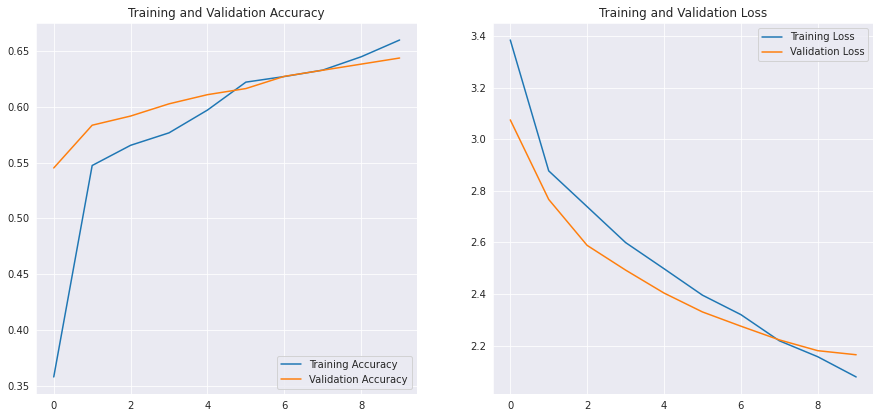

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(ep)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_images = []
for img_path in X_test:
    img_arr = cv2.imread(img_path)[...,::-1]
    resized_arr = cv2.resize(img_arr, (IMG_H, IMG_W))
    test_images.append(resized_arr)

In [25]:
test_images = np.array(test_images) / 255
test_images.reshape(-1, IMG_H, IMG_W, 1)
zzzzzzz = 0

In [26]:
predictions = np.argmax(model.predict(test_images, batch_size=BATCH_SIZE), axis=-1)
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test, predictions, target_names = ['Ignore (Class 0)','safe pedestrian (Class 1)', 'Be careful (Class 2)', 'Break (Class 3)']))

                           precision    recall  f1-score   support

         Ignore (Class 0)       0.00      0.00      0.00        77
safe pedestrian (Class 1)       0.63      0.97      0.76       287
     Be careful (Class 2)       0.50      0.06      0.10        90
          Break (Class 3)       0.67      0.72      0.69        46

                 accuracy                           0.63       500
                macro avg       0.45      0.44      0.39       500
             weighted avg       0.51      0.63      0.52       500



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
confusion = tf.math.confusion_matrix(labels=y_test, predictions=predictions, num_classes=4)
print(confusion)

tf.Tensor(
[[  0  76   1   0]
 [  0 278   2   7]
 [  0  76   5   9]
 [  0  11   2  33]], shape=(4, 4), dtype=int32)


In [28]:
saved_model_dir = 'saved_models'
tf.saved_model.save(model, saved_model_dir)

2022-12-07 09:14:12.060491: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [29]:
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

2022-12-07 09:14:45.704861: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:351] Ignored output_format.
2022-12-07 09:14:45.704942: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:354] Ignored drop_control_dependency.
2022-12-07 09:14:45.704952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored change_concat_input_ranges.
2022-12-07 09:14:45.706860: I tensorflow/cc/saved_model/reader.cc:38] Reading SavedModel from: saved_models
2022-12-07 09:14:45.772937: I tensorflow/cc/saved_model/reader.cc:90] Reading meta graph with tags { serve }
2022-12-07 09:14:45.773036: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: saved_models
2022-12-07 09:14:45.773332: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-12-07 09:14:46.012829: I tensorflow/cc/saved_mo

In [30]:
with open('mobilenet_06_12_9pm.tflite', 'wb') as f:
  f.write(tflite_model)

class ModelSpecificInfo(object):
  """Holds information that is specificly tied to an image classifier."""

  def __init__(self, name, version, image_width, image_height, image_min,
               image_max, mean, std, num_classes, author):
    self.name = name
    self.version = version
    self.image_width = image_width
    self.image_height = image_height
    self.image_min = image_min
    self.image_max = image_max
    self.mean = mean
    self.std = std
    self.num_classes = num_classes
    self.author = author

_MODEL_INFO = {
    "mobilenet_06_12_9pm.tflite":
        ModelSpecificInfo(
            name="MobileNetV2",
            version="v1",
            image_width=512,
            image_height=512,
            image_min=0,
            image_max=255,
            mean=[127.5],
            std=[127.5],
            num_classes=4,
            author="TensorFlow")
}

In [31]:
class MetadataPopulatorForImageClassifier(object):
  """Populates the metadata for an image classifier."""

  def __init__(self, model_file, model_info, label_file_path):
    self.model_file = model_file
    self.model_info = model_info
    self.label_file_path = label_file_path
    self.metadata_buf = None

  def populate(self):
    """Creates metadata and then populates it for an image classifier."""
    self._create_metadata()
    self._populate_metadata()

  def _create_metadata(self):
    """Creates the metadata for an image classifier."""

    # Creates model info.
    model_meta = _metadata_fb.ModelMetadataT()
    model_meta.name = self.model_info.name
    model_meta.description = ("Identify the most prominent object in the "
                              "image from a set of %d categories." %
                              self.model_info.num_classes)
    model_meta.version = self.model_info.version
    model_meta.author = self.model_info.author
    model_meta.license = ("Apache License. Version 2.0 "
                          "http://www.apache.org/licenses/LICENSE-2.0.")

    # Creates input info.
    input_meta = _metadata_fb.TensorMetadataT()
    input_meta.name = "image"
    input_meta.description = (
        "Input image to be classified. The expected image is {0} x {1}, with "
        "three channels (red, blue, and green) per pixel. Each value in the "
        "tensor is a single byte between {2} and {3}.".format(
            self.model_info.image_width, self.model_info.image_height,
            self.model_info.image_min, self.model_info.image_max))
    input_meta.content = _metadata_fb.ContentT()
    input_meta.content.contentProperties = _metadata_fb.ImagePropertiesT()
    input_meta.content.contentProperties.colorSpace = (
        _metadata_fb.ColorSpaceType.RGB)
    input_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.ImageProperties)
    input_normalization = _metadata_fb.ProcessUnitT()
    input_normalization.optionsType = (
        _metadata_fb.ProcessUnitOptions.NormalizationOptions)
    input_normalization.options = _metadata_fb.NormalizationOptionsT()
    input_normalization.options.mean = self.model_info.mean
    input_normalization.options.std = self.model_info.std
    input_meta.processUnits = [input_normalization]
    input_stats = _metadata_fb.StatsT()
    input_stats.max = [self.model_info.image_max]
    input_stats.min = [self.model_info.image_min]
    input_meta.stats = input_stats

    # Creates output info.
    output_meta = _metadata_fb.TensorMetadataT()
    output_meta.name = "probability"
    output_meta.description = "Probabilities of the %d labels respectively." % self.model_info.num_classes
    output_meta.content = _metadata_fb.ContentT()
    output_meta.content.content_properties = _metadata_fb.FeaturePropertiesT()
    output_meta.content.contentPropertiesType = (
        _metadata_fb.ContentProperties.FeatureProperties)
    output_stats = _metadata_fb.StatsT()
    output_stats.max = [1.0]
    output_stats.min = [0.0]
    output_meta.stats = output_stats
    label_file = _metadata_fb.AssociatedFileT()
    label_file.name = os.path.basename(self.label_file_path)
    label_file.description = "Labels for objects that the model can recognize."
    label_file.type = _metadata_fb.AssociatedFileType.TENSOR_AXIS_LABELS
    output_meta.associatedFiles = [label_file]

    # Creates subgraph info.
    subgraph = _metadata_fb.SubGraphMetadataT()
    subgraph.inputTensorMetadata = [input_meta]
    subgraph.outputTensorMetadata = [output_meta]
    model_meta.subgraphMetadata = [subgraph]

    b = flatbuffers.Builder(0)
    b.Finish(
        model_meta.Pack(b),
        _metadata.MetadataPopulator.METADATA_FILE_IDENTIFIER)
    self.metadata_buf = b.Output()

  def _populate_metadata(self):
    """Populates metadata and label file to the model file."""
    populator = _metadata.MetadataPopulator.with_model_file(self.model_file)
    populator.load_metadata_buffer(self.metadata_buf)
    populator.load_associated_files([self.label_file_path])
    populator.populate()


In [32]:
import flatbuffers
model_file = "mobilenet_06_12_9pm.tflite"
model_basename = os.path.basename(model_file)

export_model_path = os.path.join(saved_model_dir, model_basename)

# Copies model_file to export_path.
tf.io.gfile.copy(model_file, export_model_path, overwrite=True)

# Generate the metadata objects and put them in the model file
populator = MetadataPopulatorForImageClassifier(
  export_model_path, _MODEL_INFO.get(model_file), "../input/citypersondata-annot/labels.txt")
populator.populate()

In [33]:
displayer = _metadata.MetadataDisplayer.with_model_file(export_model_path)
export_json_file = os.path.join(saved_model_dir, os.path.splitext(model_basename)[0] + ".json")
json_file = displayer.get_metadata_json()
with open(export_json_file, "w") as f:
    f.write(json_file)

In [34]:
print("Finished populating metadata and associated file to the model:")
print(model_file)
print("The metadata json file has been saved to:")
print(export_json_file)
print("The associated file that has been been packed to the model is:")
print(displayer.get_packed_associated_file_list())

Finished populating metadata and associated file to the model:
mobilenet_06_12_9pm.tflite
The metadata json file has been saved to:
saved_models/mobilenet_06_12_9pm.json
The associated file that has been been packed to the model is:
['labels.txt']
